In [1]:
import os
import SimpleITK as sitk
import six
from radiomics import featureextractor as fe
import radiomics
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import scipy
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from matplotlib.figure import Figure
import package_outlier as po
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr

In [2]:
def nii_to_arr(nii_file):
    sitk_img = sitk.ReadImage(nii_file)
    origin = sitk_img.GetOrigin()
    spacing = sitk_img.GetSpacing()
    assert(spacing[2] == 12.)
    arr = sitk.GetArrayFromImage(sitk_img)
    
    return origin, spacing, arr

In [3]:
def extract_chamber(segmentation_file, intensity):
    origin, spacing, img_arr = nii_to_arr(segmentation_file)
    assert(spacing[2] == 12.)
    img_arr_roi = np.where(img_arr == intensity, 1., 0.)
    return origin, spacing, img_arr_roi

def extract_voxel(nii_file):
    sitk_img = sitk.ReadImage(nii_file)
    assert(sitk_img.GetSpacing()[2])
    return sitk_img.GetSpacing()[0]*sitk_img.GetSpacing()[1]*sitk_img.GetSpacing()[2]

In [4]:
def chamber_vol_func(patient_id, num_images, t_start, nnunet_images_prefix):

    nnunet_folder = nnunet_path + 'EXH' + patient_id + '/REST/z_12/all_slices/'

    for comp in ['LV','LVMC']:
        vol = []
        t_end = t_start + num_images
        for t in range(t_start,t_end):
            rest_maskName = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + nnunet_images_suffix
            origin, spacing, rest_chamber = extract_chamber(rest_maskName, chamber_intensity[comp])    
            voxel_vol = extract_voxel(rest_maskName)
            vol.append(np.sum(rest_chamber)*voxel_vol)
        chamber_volume_nnunet[comp] = vol
    return chamber_volume_nnunet

In [5]:
chamber_volume_nnunet = {}
chamber_intensity = {'LV': 3.,
                    'LVMC': 2., 
                    }

In [6]:
nnunet_path = '/Users/saurabh/sample/uh_images/'

#### Plot volume vs time

In [7]:
nnunet_images_suffix = '.nii.gz'

def plot_vol_vs_time(patient_id):

    nnunet_folder = nnunet_path + 'EXH' + patient_id + '/REST/z_12/all_slices/'
    nnunet_images_prefix = 'EXH' + patient_id + '_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    if patient_id == '100B':
        nnunet_images_prefix = 'EXH' + patient_id + '_CINE_SET-UP-8SAX-1VLA-1HLA_'

    num_images = len(glob.glob(nnunet_folder+'*.gz'))

    t_start = 0

    chamber_volume_nnunet = chamber_vol_func(patient_id, num_images, t_start, nnunet_images_prefix)
    plt.scatter(np.arange(num_images),chamber_volume_nnunet['LV'],label='LV')
    plt.scatter(np.arange(num_images),chamber_volume_nnunet['LVMC'],label='LVMC')
    #plt.xlim(0,11)
    plt.legend();

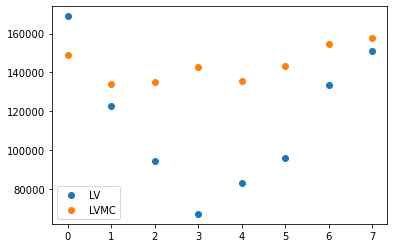

In [8]:
plot_vol_vs_time('175')

### Volume Features

In [8]:
path = os.getcwd()
path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH'

In [10]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns='Unnamed: 0',inplace=True);
vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,153,1362.454538,19.772862,78788.250000,85015.500000,85489.312500,73305.562500,0,0.142518,7965.467931,3.028929,39664.875000,106269.375000,66604.500000,0.626752
1,154,1170.807087,26.140431,109586.062500,103155.750000,109586.062500,94762.500000,1,0.135269,9425.673423,3.012396,46027.500000,130027.687500,84000.187500,0.646018
2,162,931.932994,27.155585,71613.375000,71071.875000,75674.625000,67416.750000,0,0.109123,4889.557224,4.245226,38920.312500,81428.062500,42507.750000,0.522028
3,191,628.804706,34.786485,113767.084884,103040.360091,114963.373894,103040.360091,0,0.103711,6097.426044,3.482814,58658.037807,151888.828014,93230.790206,0.613809
4,109,2522.159368,18.556770,111413.625000,126507.937500,135239.625000,111413.625000,0,0.176176,15817.902632,2.284888,42440.062500,153447.562500,111007.500000,0.723423


In [11]:
vol_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lvmc_std,57.0,1797.558352,978.553481,628.804706,1153.427697,1576.147548,2157.732959,5292.798928
lvmc_snr,57.0,23.563425,9.398134,6.777910,16.904342,21.800929,29.353887,51.752073
lvmc_vol_es,57.0,119454.560966,34094.778466,66739.875000,99432.937500,111481.312500,136187.250000,245279.123421
lvmc_vol_ed,57.0,117516.593433,26976.081444,65995.312500,101531.250000,113095.916148,131003.510365,200697.419636
lvmc_vol_max,57.0,127911.039980,32967.862905,71816.437500,109586.062500,122446.687500,143159.062500,249944.650562
lvmc_vol_min,57.0,108822.267145,27850.475428,59294.250000,91613.147363,106018.453125,128538.562500,200697.419636
lvmc_vol_es_equal_max,57.0,0.192982,0.398147,0.000000,0.000000,0.000000,0.000000,1.000000
lvmc_vol_max_minus_min,57.0,0.147485,0.058346,0.051396,0.107206,0.135528,0.180286,0.321380
lv_std,57.0,8757.182215,3055.657135,1293.227392,7026.437692,9064.454540,10607.786669,15817.902632
lv_snr,57.0,4.544664,3.082525,2.119069,3.227912,3.573549,4.431670,16.560371


In [37]:
vol_columns = vol_df.columns
numerical_columns = vol_columns.drop(['patient_id','lvmc_vol_es_equal_max']).values

In [38]:
vol_df.shape

(51, 15)

In [39]:
vol_df_scaled = vol_df.copy(deep=True)
vol_df_scaled[numerical_columns] = scaler.fit_transform(vol_df[numerical_columns])

#### Outlier analysis

Let's look at the outliers. The purpose of doing outlier analysis is to go back and check the raw images and do appropriate corrections on the segmentations if required. Low ejection fraction cases can be excluded from further analysis since it is a known cause of dyspnea. 

In [13]:
def outlier_func(df, numerical_columns, num_ouliers_min):
    '''
    Finds features with outliers
    '''
    outlier_features = []
    for feature in numerical_columns:
        outliers = po.ModifiedZscoreOutlier(df[feature].values)
        num_outliers = len(outliers)
        if num_outliers > num_ouliers_min:
            outlier_features.append(feature)
    return outlier_features

In [14]:
outlier_features = outlier_func(vol_df, numerical_columns, 3)
outlier_features

['lv_snr', 'stroke_volume', 'ejection_fraction']

<AxesSubplot:>

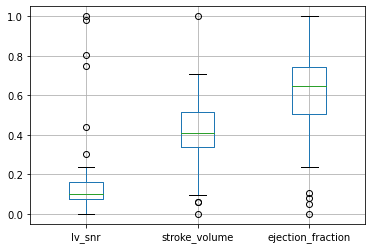

In [15]:
vol_df_scaled.boxplot(column = outlier_features[:])

In [17]:
feature = 'ejection_fraction'
outliers = po.ModifiedZscoreOutlier(vol_df[feature].values)
num_outliers = len(outliers)
print('number of outliers = ',num_outliers)

number of outliers =  4


In [18]:
vol_df.sort_values(by=[feature],ascending=True).head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
50,188,1153.427697,51.752073,138101.296538,131003.510365,138101.296538,131003.510365,1,0.051396,5913.262444,12.932917,148442.441956,182004.159358,33561.717402,0.184401
20,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.000000,0,0.181696,1293.227392,16.560371,92190.375000,117302.437500,25112.062500,0.214080
9,100B,2806.696077,11.717112,122988.187500,164616.000000,164616.000000,118114.687500,0,0.282484,2768.218732,16.263933,164954.437500,215178.562500,50224.125000,0.233407
12,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.375000,0,0.112928,1969.364777,13.761918,102096.093750,136032.421875,33936.328125,0.249472
54,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.437500,0,0.142547,3033.372628,8.487487,78179.062500,116693.250000,38514.187500,0.330046


In [16]:
vol_df = vol_df.drop(index=50)

In [20]:
vol_df[vol_df['ejection_fraction'] < 0.4].sort_values(by=[feature],ascending=True)

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
20,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.0000,0,0.181696,1293.227392,16.560371,92190.37500,117302.437500,25112.062500,0.214080
9,100B,2806.696077,11.717112,122988.187500,164616.000000,164616.000000,118114.6875,0,0.282484,2768.218732,16.263933,164954.43750,215178.562500,50224.125000,0.233407
12,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.3750,0,0.112928,1969.364777,13.761918,102096.09375,136032.421875,33936.328125,0.249472
54,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.4375,0,0.142547,3033.372628,8.487487,78179.06250,116693.250000,38514.187500,0.330046
48,111,1603.417244,15.159323,117975.000000,121875.000000,130275.000000,106575.0000,0,0.181923,3565.792521,6.507337,88800.00000,142875.000000,54075.000000,0.378478


In [17]:
low_lv_ef = vol_df[vol_df['ejection_fraction'] < 0.4].patient_id.values
low_lv_ef

array(['100B', '123', '114', '111', '119'], dtype=object)

In [18]:
vol_df = vol_df[~vol_df['patient_id'].isin(low_lv_ef)]
vol_df.shape

(51, 15)

In [19]:
cpet_file = path + '/ExerciseMRIEvaluatio_DATA_LABELS_2021-03-16_1304.xlsx'
cpet_data = pd.read_excel(cpet_file)

In [20]:
cpet_data.dropna(subset=['VO2 (MAX):'],inplace=True)
cpet_data.dropna(subset=['VO2 %Predicted '],inplace=True)
cpet_data.shape

(67, 662)

In [21]:
cpet_data.loc[cpet_data['VO2 %Predicted '] < 80., 'dyspnea'] = int(1)
cpet_data.loc[cpet_data['VO2 %Predicted '] >= 80., 'dyspnea'] = int(0)

In [22]:
Counter(cpet_data['dyspnea'])

Counter({1.0: 43, 0.0: 24})

In [ ]:
cpet_data.columns.values

In [27]:
cpet_data[['Record ID', 'PetCO2', 'PetCO2.2', 'VO2 (MAX):', 'Weight (kg):', 'VO2/kg (MAX):']]

,Record ID,PetCO2,PetCO2.2,VO2 (MAX):,Weight (kg):,VO2/kg (MAX):
0,100,17.0,26.0,2.05,77.7,26.4
1,101,19.0,25.0,1.52,75.3,20.1
2,103,22.0,39.0,2.36,142.7,16.6
3,105,17.0,30.0,2.53,116.6,21.7
4,109,24.0,27.0,1.23,137.7,8.9
...,...,...,...,...,...,...
73,197,32.0,35.0,1.83,64.9,28.2
74,198,34.0,34.0,1.56,72.7,21.5
75,199,32.0,43.0,1.75,76.9,22.7
76,200,29.0,39.0,1.63,78.4,20.8


#### U Test with volumetric features

In [23]:
def u_test_func(df, numerical_columns):
    '''
    Performs Mann Whitney u test
    '''
    num_rows = df.shape[0]
    u_test_features = []

    for feature in numerical_columns:
        dyspnea_arr = []
        normal_arr = []

        for n in range(num_rows):
            arr = df.iloc[n][feature]
            pid = df.iloc[n]['patient_id']
            num_pid = int(pid[0:3])
            cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
            condition = cpet_record['dyspnea']
            if condition.values[0] == 1.:
                dyspnea_arr.append(arr)
            else:
                normal_arr.append(arr)
        res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
        u_test_features.append((feature,res.pvalue))    
    return u_test_features, dyspnea_arr, normal_arr

In [40]:
u_test_vol_features, _, _ = u_test_func(vol_df, numerical_columns)

In [41]:
significant_feat = [ent for ent in u_test_vol_features if ent[1] < 0.09]
print('significant features: (feature name, p-value)\n', [(ent[0], round(ent[1],4)) for ent in significant_feat])

significant features: (feature name, p-value)
 [('lvmc_vol_ed', 0.0879), ('lv_std', 0.0499)]


In [42]:
important_features = []
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed', 'lv_std']

In [43]:
def box_plot_func(title1, title2, df, feature1, feature2, y1, y2):
    fig = Figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title1,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature1])
    ax.boxplot([dyspnea_arr, normal_arr])
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y1,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(title2,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature2])
    ax.boxplot([dyspnea_arr, normal_arr])
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y2,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    return fig

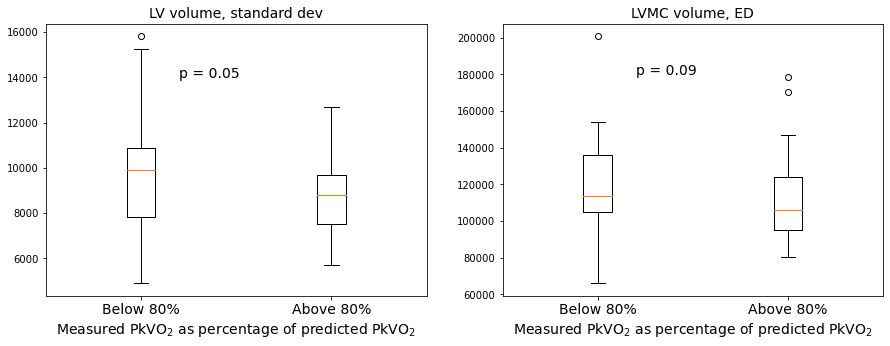

In [44]:
box_plot_func('LV volume, standard dev', 'LVMC volume, ED',  vol_df, 'lv_std', 'lvmc_vol_ed', 14000, 180000)

#### Correlation analysis

In [45]:
pids = vol_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])    

In [46]:
vol_df['pkvo2'] = pkvo2_vals
vol_df['petco2'] = petco2_vals

In [47]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), "{:.2e}".format(pearson_val[1])))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lvmc_vol_min', 0.279, '6.75e-05')
('lv_vol_es', 0.263, '1.20e-04')
('lvmc_vol_ed', 0.255, '1.57e-04')
('lv_vol_ed', 0.234, '3.23e-04')
('lvmc_vol_es', 0.224, '4.60e-04')
('lvmc_vol_max', 0.211, '6.93e-04')
('lv_snr', 0.131, '9.13e-03')
('ejection_fraction', 0.107, '1.93e-02')


In [48]:
important_features.append('lvmc_vol_min')
important_features

['lvmc_vol_ed', 'lv_std', 'lvmc_vol_min']

In [49]:
null_petco2_pids = vol_df[vol_df['petco2'].isna()].patient_id.values
print('patient ids with missing Pet CO2 \n', null_petco2_pids)

patient ids with missing Pet CO2 
 ['135']


In [50]:
response = vol_df[~vol_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[~vol_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lv_vol_ed', 0.321, 1.8e-05)
('stroke_volume', 0.238, 0.000328)
('lv_vol_es', 0.184, 0.001898)
('lvmc_vol_max', 0.151, 0.005288)
('lvmc_vol_es', 0.146, 0.006191)
('lvmc_vol_min', 0.141, 0.007303)
('lvmc_vol_ed', 0.13, 0.010188)


In [51]:
important_features.extend(['lv_vol_ed', 'stroke_volume', 'lvmc_vol_max'])

### Pyradiomics 3d features

In [52]:
pyrads_3d_df = pd.read_csv('pyrads_3d.csv')
pyrads_3d_df.drop(columns='Unnamed: 0',inplace=True);
pyrads_3d_df.tail()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterRow,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,patient_id
52,0.506334,0.495642,35.047752,63.474620,68.597103,69.779228,42.085107,71.850213,56400.609375,36.507579,...,95.353372,62.476496,97.227906,155348.453125,51.860836,0.759987,18388.619097,0.118370,156831.9375,181
53,0.433687,0.405421,36.375446,73.163911,83.735073,81.412530,48.904243,88.452318,80641.195312,39.807814,...,98.924529,65.689254,103.712343,159982.226562,57.096478,0.781472,18236.940063,0.113994,161434.6875,121
54,0.442772,0.411883,39.077575,75.216261,82.547808,86.256884,51.379106,86.778454,76836.593750,42.008184,...,94.252652,59.375000,95.707644,115302.835938,49.954742,0.753739,15199.286437,0.131821,116693.2500,119
55,0.534887,0.501297,38.785281,71.689403,78.340702,80.331442,51.269204,81.585557,76698.398438,41.384085,...,95.353372,68.009650,96.412282,174357.359375,56.197915,0.750116,20120.974777,0.115401,175919.8125,126
56,0.352793,0.329828,26.018235,77.215350,72.351680,81.412530,36.252802,81.723715,26059.687500,27.829834,...,98.894199,58.223841,101.761517,107138.031250,47.723800,0.663028,16453.116964,0.153569,108773.8125,113B


In [65]:
pyrads_3d_df.describe().T

,count,mean,std,min,25%,50%,75%,max
min_original_shape_Elongation,57.0,0.484974,0.063580,0.337322,0.449481,0.493708,0.534887,0.599829
min_original_shape_Flatness,57.0,0.433950,0.056031,0.315769,0.399846,0.440029,0.485829,0.533986
min_original_shape_LeastAxisLength,57.0,34.939201,5.283151,23.784889,31.718557,34.641259,38.210702,49.817307
min_original_shape_MajorAxisLength,57.0,74.823154,10.610705,51.937018,66.514456,73.629509,82.730094,101.394964
min_original_shape_Maximum2DDiameterColumn,57.0,81.483519,10.445174,62.936476,75.815978,79.306762,88.131216,110.193083
...,...,...,...,...,...,...,...,...
ed_val_original_shape_MinorAxisLength,57.0,52.770056,4.563227,42.437262,49.954742,52.213807,55.639177,63.041983
ed_val_original_shape_Sphericity,57.0,0.743139,0.042845,0.624884,0.723229,0.753739,0.773154,0.806397
ed_val_original_shape_SurfaceArea,57.0,18330.127847,3231.018300,12633.063217,16270.985150,17507.641426,20510.673146,27561.485427
ed_val_original_shape_SurfaceVolumeRatio,57.0,0.124394,0.012305,0.105672,0.115210,0.122641,0.129681,0.159521


In [30]:
low_lv_ef = np.append(low_lv_ef,'188')

In [53]:
pyrads_3d_df = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(low_lv_ef)]
pyrads_3d_df.shape

(51, 113)

In [54]:
pyrads_3d_columns = pyrads_3d_df.columns
numerical_columns = pyrads_3d_columns.drop(['patient_id']).values

In [55]:
outlier_features = outlier_func(pyrads_3d_df, numerical_columns, 4)
outlier_features

['std_dev_original_shape_Maximum2DDiameterSlice',
 'snr_original_shape_MajorAxisLength',
 'snr_original_shape_Maximum2DDiameterRow',
 'snr_original_shape_Maximum2DDiameterSlice',
 'snr_original_shape_Sphericity']

In [56]:
pyrads_3d_df_scaled = pyrads_3d_df.copy(deep=True)
pyrads_3d_df_scaled[numerical_columns] = scaler.fit_transform(pyrads_3d_df[numerical_columns])

<AxesSubplot:>

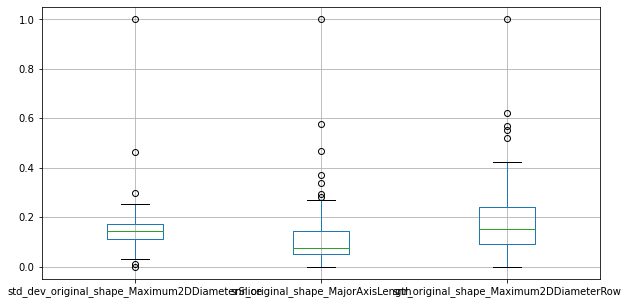

In [45]:
pyrads_3d_df_scaled.boxplot(column = outlier_features[0:3], figsize = (10,5))

<AxesSubplot:>

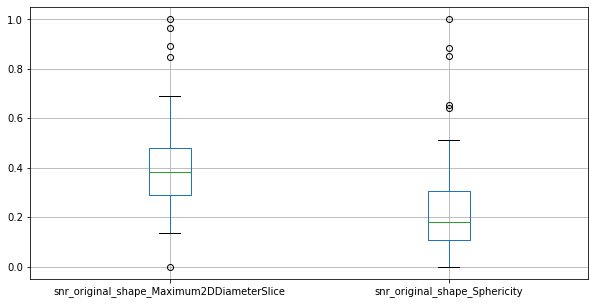

In [46]:
pyrads_3d_df_scaled.boxplot(column = outlier_features[3:], figsize = (10,5))

In [59]:
u_test_pyrads_3d_features, _, _ = u_test_func(pyrads_3d_df, numerical_columns)

In [60]:
significant_feat = [ent for ent in u_test_pyrads_3d_features if ent[1] < 0.05]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
median_original_shape_Sphericity 0.023
mean_original_shape_Sphericity 0.03
max_original_shape_SurfaceArea 0.039
es_val_original_shape_Sphericity 0.041
mean_original_shape_SurfaceArea 0.044
ed_val_original_shape_SurfaceArea 0.044
min_original_shape_Sphericity 0.05


In [50]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed',
 'lv_std',
 'lvmc_vol_min',
 'lv_vol_ed',
 'stroke_volume',
 'lvmc_vol_max',
 'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea']

In [51]:
pids = pyrads_3d_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])  
    
pyrads_3d_df['pkvo2'] = pkvo2_vals
pyrads_3d_df['petco2'] = petco2_vals

In [52]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

('min_original_shape_VoxelVolume', 0.263, 0.00012)
('es_val_original_shape_VoxelVolume', 0.263, 0.00012)
('min_original_shape_MeshVolume', 0.262, 0.000125)
('es_val_original_shape_MeshVolume', 0.262, 0.000125)
('mean_original_shape_VoxelVolume', 0.252, 0.000176)
('mean_original_shape_MeshVolume', 0.251, 0.000182)
('median_original_shape_MeshVolume', 0.25, 0.000189)
('median_original_shape_VoxelVolume', 0.25, 0.000188)
('median_original_shape_SurfaceVolumeRatio', 0.246, 0.000217)
('mean_original_shape_SurfaceVolumeRatio', 0.244, 0.000233)
('max_original_shape_VoxelVolume', 0.234, 0.000323)
('ed_val_original_shape_VoxelVolume', 0.234, 0.000323)
('min_original_shape_SurfaceArea', 0.232, 0.000348)
('max_original_shape_MeshVolume', 0.232, 0.000341)
('ed_val_original_shape_MeshVolume', 0.232, 0.000341)
('median_original_shape_LeastAxisLength', 0.229, 0.000385)
('es_val_original_shape_SurfaceArea', 0.229, 0.000386)
('max_original_shape_SurfaceVolumeRatio', 0.228, 0.000398)
('es_val_original_s

In [53]:
important_features.extend(['min_original_shape_VoxelVolume', 'mean_original_shape_LeastAxisLength', \
        'median_original_shape_SurfaceVolumeRatio', 'median_original_shape_MinorAxisLength',\
        'ed_val_original_shape_Maximum3DDiameter', 'max_original_shape_Maximum2DDiameterColumn'])

In [54]:
response = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

significant features: 
(feature name, R^2, p-value)

('max_original_shape_Maximum2DDiameterRow', 0.409, 1e-06)
('ed_val_original_shape_Maximum2DDiameterRow', 0.399, 1e-06)
('ed_val_original_shape_Maximum3DDiameter', 0.382, 2e-06)
('mean_original_shape_Maximum2DDiameterRow', 0.359, 4e-06)
('mean_original_shape_Maximum3DDiameter', 0.337, 1e-05)
('median_original_shape_Maximum2DDiameterRow', 0.327, 1.4e-05)
('max_original_shape_MeshVolume', 0.321, 1.8e-05)
('max_original_shape_VoxelVolume', 0.321, 1.8e-05)
('ed_val_original_shape_MeshVolume', 0.321, 1.8e-05)
('ed_val_original_shape_VoxelVolume', 0.321, 1.8e-05)
('max_original_shape_Maximum2DDiameterColumn', 0.314, 2.3e-05)
('median_original_shape_Maximum3DDiameter', 0.311, 2.6e-05)
('mean_original_shape_MajorAxisLength', 0.31, 2.7e-05)
('ed_val_original_shape_Maximum2DDiameterColumn', 0.294, 4.7e-05)
('ed_val_original_shape_MajorAxisLength', 0.289, 5.7e-05)
('mean_original_shape_Maximum2DDiameterColumn', 0.288, 5.8e-05)
('max_original_sha

In [55]:
important_features.extend(['max_original_shape_Maximum2DDiameterRow', 'mean_original_shape_Maximum3DDiameter',\
            'max_original_shape_MeshVolume', 'max_original_shape_Maximum2DDiameterColumn',\
            'ed_val_original_shape_MajorAxisLength'])

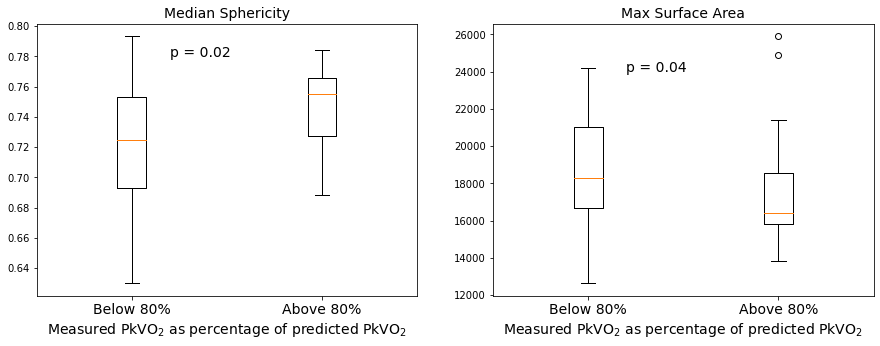

In [61]:
box_plot_func('Median Sphericity', 'Max Surface Area',  pyrads_3d_df, \
        'median_original_shape_Sphericity', 'max_original_shape_SurfaceArea', 0.78, 24000)

### 3D Fractal features

In [62]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns='Unnamed: 0',inplace=True);
fractals_3d_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.479988,7.346413,1.963456,6.064861,2.275728,6.760670,2.342396,6.886595,2.458897,7.346413,...,6.965695,2.273299,7.181236,2.275288,7.238113,2.239110,7.315423,2.271066,7.039687,153
1,2.413301,7.404196,2.186582,6.476394,2.322058,7.036596,2.344578,7.186857,2.413301,7.404196,...,7.484620,2.338499,7.544748,2.324051,7.543040,2.324051,7.531694,2.377132,7.528839,154
2,2.366648,7.101825,2.074160,6.248441,2.213915,6.648769,2.183091,6.642925,2.366648,7.101825,...,6.980443,2.232655,7.121495,2.242075,7.118396,2.310661,7.293535,2.249362,7.070714,162
3,2.558215,8.257276,2.322868,7.386463,2.478927,7.865453,2.493921,7.980278,2.558215,8.257276,...,7.982848,2.421854,8.162983,2.426577,8.204169,2.409906,8.211593,2.420886,8.054498,191
4,2.557690,7.792839,2.048207,6.216915,2.405354,7.158140,2.426958,7.246218,2.555350,7.792839,...,7.537170,2.417745,7.761672,2.432243,7.819010,2.437533,7.942699,2.347765,7.537170,109


In [63]:
fractals_3d_df = fractals_3d_df[~fractals_3d_df['patient_id'].isin(low_lv_ef)]
fractals_3d_df.shape

(51, 25)

In [64]:
fractals_3d_columns = fractals_3d_df.columns
numerical_columns = fractals_3d_columns.drop(['patient_id']).values

In [65]:
outlier_features = outlier_func(fractals_3d_df, numerical_columns, 4)
outlier_features

['lv_ed_inc', 'lvmc_es_inc']

In [66]:
fractals_3d_df_scaled = fractals_3d_df.copy(deep=True)
fractals_3d_df_scaled[numerical_columns] = scaler.fit_transform(fractals_3d_df[numerical_columns])

<AxesSubplot:>

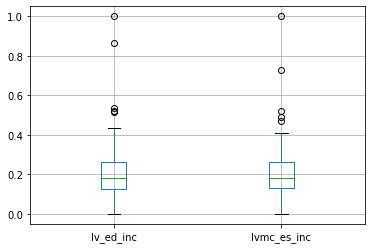

In [61]:
fractals_3d_df_scaled.boxplot(column = list(outlier_features))

#### U test with 3d fractal features

In [67]:
u_test_fractals_3d_features, _, _ = u_test_func(fractals_3d_df, numerical_columns)

In [68]:
significant_feat = [ent for ent in u_test_fractals_3d_features if ent[1] < 0.08]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_min_slope 0.071
lvmc_min_slope 0.071


In [64]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed',
 'lv_std',
 'lvmc_vol_min',
 'lv_vol_ed',
 'stroke_volume',
 'lvmc_vol_max',
 'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceVolumeRatio',
 'median_original_shape_MinorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'max_original_shape_Maximum2DDiameterColumn',
 'max_original_shape_Maximum2DDiameterRow',
 'mean_original_shape_Maximum3DDiameter',
 'max_original_shape_MeshVolume',
 'max_original_shape_Maximum2DDiameterColumn',
 'ed_val_original_shape_MajorAxisLength',
 'lv_min_slope',
 'lvmc_min_slope']

In [66]:
pids = fractals_3d_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])    
    
fractals_3d_df['pkvo2'] = pkvo2_vals
fractals_3d_df['petco2'] = petco2_vals

In [67]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],3)))
print('significant features: (feature name, p-value)')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: (feature name, p-value)


In [68]:
response = fractals_3d_df[~fractals_3d_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[~fractals_3d_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

significant features: 
(feature name, R^2, p-value)



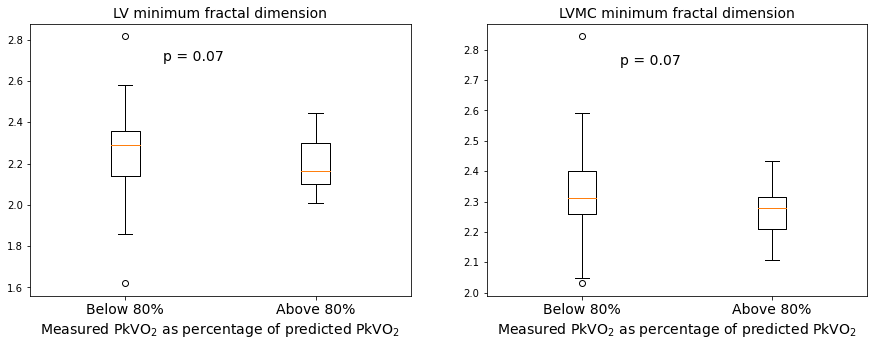

In [69]:
box_plot_func('LV minimum fractal dimension', 'LVMC minimum fractal dimension',  fractals_3d_df, \
        'lv_min_slope', 'lvmc_min_slope', 2.7, 2.75)

## Multivariate Analysis

In [69]:
important_features = list(set(important_features))
important_features

['lvmc_vol_max',
 'mean_original_shape_LeastAxisLength',
 'max_original_shape_MeshVolume',
 'ed_val_original_shape_SurfaceArea',
 'mean_original_shape_SurfaceArea',
 'max_original_shape_SurfaceArea',
 'max_original_shape_Maximum2DDiameterRow',
 'lv_std',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_Sphericity',
 'min_original_shape_Sphericity',
 'lvmc_min_slope',
 'max_original_shape_Maximum2DDiameterColumn',
 'lvmc_vol_min',
 'median_original_shape_SurfaceVolumeRatio',
 'lvmc_vol_ed',
 'mean_original_shape_Maximum3DDiameter',
 'lv_min_slope',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_MajorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'median_original_shape_MinorAxisLength',
 'stroke_volume',
 'lv_vol_ed']

In [70]:
pyrads_df = pd.read_csv('pyrads_3d.csv')
pyrads_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(pyrads_df.columns.values) & set(important_features))
pyrads_df_imp = pyrads_df[['patient_id']+common_features]
pyrads_df_imp.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,max_original_shape_SurfaceArea,max_original_shape_Maximum2DDiameterRow,mean_original_shape_Maximum3DDiameter,median_original_shape_SurfaceVolumeRatio,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_MajorAxisLength,min_original_shape_VoxelVolume
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,14611.078910,92.195445,86.670798,0.153127,0.748158,0.723153,79.810201,39664.875000
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,15848.950767,89.494501,84.667249,0.134614,0.767928,0.734934,80.581778,46027.500000
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,12633.063217,81.412530,82.550290,0.174758,0.712053,0.704503,76.028604,38920.312500
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,19440.135711,120.244185,112.610973,0.145488,0.685203,0.646605,102.319481,58658.037807
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,18885.775024,101.595091,88.857282,0.149964,0.728897,0.737380,89.894066,42440.062500


In [71]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(vol_df.columns.values) & set(important_features))
vol_df_imp = vol_df[['patient_id']+common_features]
vol_df_imp.head()

,patient_id,lvmc_vol_max,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed
0,153,85489.312500,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000
1,154,109586.062500,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500
2,162,75674.625000,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500
3,191,114963.373894,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014
4,109,135239.625000,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500


In [72]:
important_features_df = pd.merge(pyrads_df_imp, vol_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,...,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_MajorAxisLength,min_original_shape_VoxelVolume,lvmc_vol_max,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,...,0.748158,0.723153,79.810201,39664.875000,85489.312500,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,...,0.767928,0.734934,80.581778,46027.500000,109586.062500,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,...,0.712053,0.704503,76.028604,38920.312500,75674.625000,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,...,0.685203,0.646605,102.319481,58658.037807,114963.373894,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,...,0.728897,0.737380,89.894066,42440.062500,135239.625000,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500


In [73]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(fractals_3d_df.columns.values) & set(important_features))
fractals_3d_df_imp = fractals_3d_df[['patient_id']+common_features]
fractals_3d_df_imp.head()

,patient_id,lv_min_slope,lvmc_min_slope
0,153,1.963456,2.224151
1,154,2.186582,2.288623
2,162,2.074160,2.137551
3,191,2.322868,2.354578
4,109,2.048207,2.335396


In [74]:
important_features_df = pd.merge(important_features_df, fractals_3d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,...,ed_val_original_shape_MajorAxisLength,min_original_shape_VoxelVolume,lvmc_vol_max,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed,lv_min_slope,lvmc_min_slope
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,...,79.810201,39664.875000,85489.312500,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000,1.963456,2.224151
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,...,80.581778,46027.500000,109586.062500,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500,2.186582,2.288623
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,...,76.028604,38920.312500,75674.625000,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500,2.074160,2.137551
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,...,102.319481,58658.037807,114963.373894,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014,2.322868,2.354578
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,...,89.894066,42440.062500,135239.625000,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500,2.048207,2.335396


In [75]:
important_features_df = important_features_df[~important_features_df['patient_id'].isin(low_lv_ef)].copy(deep=True)
important_features_df.shape

(51, 26)

In [76]:
important_features_columns = important_features_df.columns
important_features_columns

Index(['patient_id', 'mean_original_shape_Sphericity',
       'max_original_shape_MeshVolume', 'mean_original_shape_LeastAxisLength',
       'min_original_shape_Sphericity',
       'max_original_shape_Maximum2DDiameterColumn',
       'ed_val_original_shape_SurfaceArea',
       'ed_val_original_shape_Maximum3DDiameter',
       'mean_original_shape_SurfaceArea',
       'median_original_shape_MinorAxisLength',
       'max_original_shape_SurfaceArea',
       'max_original_shape_Maximum2DDiameterRow',
       'mean_original_shape_Maximum3DDiameter',
       'median_original_shape_SurfaceVolumeRatio',
       'median_original_shape_Sphericity', 'es_val_original_shape_Sphericity',
       'ed_val_original_shape_MajorAxisLength',
       'min_original_shape_VoxelVolume', 'lvmc_vol_max', 'lvmc_vol_min',
       'lvmc_vol_ed', 'lv_std', 'stroke_volume', 'lv_vol_ed', 'lv_min_slope',
       'lvmc_min_slope'],
      dtype='object')

In [77]:
numerical_columns = important_features_columns.drop('patient_id').values
important_features_df_scaled = important_features_df.copy(deep=True)
important_features_df_scaled[numerical_columns] = scaler.fit_transform(important_features_df[numerical_columns])

<AxesSubplot:>

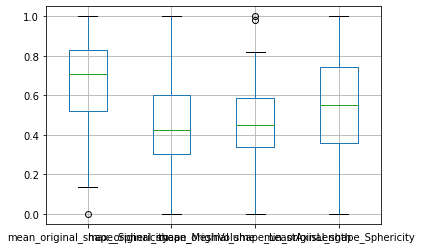

In [78]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[0:4])

<AxesSubplot:>

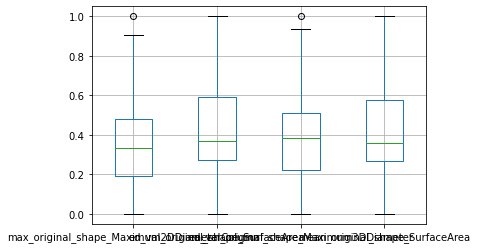

In [79]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[4:8])

In [81]:
vo2_max = []
num_rows = important_features_df.shape[0]
for n in range(num_rows):
    pid = important_features_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    vo2_max.append((pid,cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0],\
                          cpet_record['PetCO2.2'].values[0]))

In [82]:
important_features_df['pkvo2'] = [ent[1] for ent in vo2_max]
important_features_df['dyspnea'] = [ent[2] for ent in vo2_max]
important_features_df['petco2'] = [ent[3] for ent in vo2_max]

In [83]:
important_features_df.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,...,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed,lv_min_slope,lvmc_min_slope,pkvo2,dyspnea,petco2
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,...,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000,1.963456,2.224151,1.14,1.0,22.0
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,...,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500,2.186582,2.288623,1.87,0.0,30.0
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,...,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500,2.074160,2.137551,0.59,1.0,14.0
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,...,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014,2.322868,2.354578,1.67,1.0,36.0
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,...,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500,2.048207,2.335396,1.23,1.0,27.0


In [84]:
response = important_features_df['pkvo2'] 
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(important_features_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lvmc_vol_min', 0.279, 6.8e-05)
('min_original_shape_VoxelVolume', 0.263, 0.00012)
('lvmc_vol_ed', 0.255, 0.000157)
('median_original_shape_SurfaceVolumeRatio', 0.246, 0.000217)
('lv_vol_ed', 0.234, 0.000323)
('max_original_shape_MeshVolume', 0.232, 0.000341)
('mean_original_shape_LeastAxisLength', 0.218, 0.000555)
('median_original_shape_MinorAxisLength', 0.218, 0.000558)
('lvmc_vol_max', 0.211, 0.000693)
('mean_original_shape_SurfaceArea', 0.201, 0.000962)
('ed_val_original_shape_SurfaceArea', 0.187, 0.001529)
('ed_val_original_shape_Maximum3DDiameter', 0.185, 0.001642)
('max_original_shape_Maximum2DDiameterColumn', 0.183, 0.001734)
('max_original_shape_SurfaceArea', 0.178, 0.002041)
('mean_original_shape_Maximum3DDiameter', 0.158, 0.003931)
('max_original_shape_Maximum2DDiameterRow', 0.14, 0.006786)
('ed_val_original_shape_MajorAxisLength', 0.105, 0.020087)


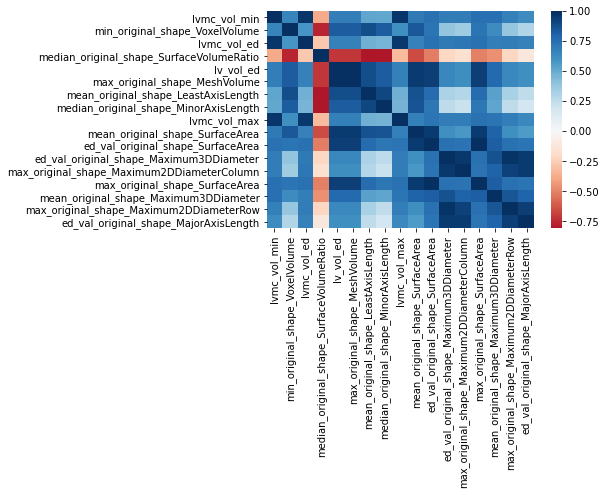

In [85]:
sns.heatmap(important_features_df[[ent[0] for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) \
                                   if ent[1] > 0.1]].corr(),cmap = 'RdBu', center = 0.0);

In [86]:
important_features_subset = ['lvmc_vol_min', 'median_original_shape_SurfaceVolumeRatio']
vif_values = [vif(important_features_df_scaled[important_features_subset].values, i) for i in range(len(important_features_subset))]
vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

median_original_shape_SurfaceVolumeRatio 1.6
lvmc_vol_min 1.6


In [87]:
multivariate_x = important_features_df_scaled[important_features_subset]
multivariate_y = important_features_df[['pkvo2']]

In [88]:
reg = LinearRegression().fit(multivariate_x, multivariate_y)
print('R^2 score =',round(reg.score(multivariate_x, multivariate_y),3))

R^2 score = 0.383


In [89]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     'y': multivariate_y.pkvo2.values})

In [90]:
model = ols("y ~ x0 + x1 ", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     14.92
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           9.15e-06
Time:                        10:24:32   Log-Likelihood:                -33.424
No. Observations:                  51   AIC:                             72.85
Df Residuals:                      48   BIC:                             78.64
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7620      0.204      8.650      0.0

In [91]:
response = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)]['petco2'] 
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('max_original_shape_Maximum2DDiameterRow', 0.409, 1e-06)
('ed_val_original_shape_Maximum3DDiameter', 0.382, 2e-06)
('mean_original_shape_Maximum3DDiameter', 0.337, 1e-05)
('max_original_shape_MeshVolume', 0.321, 1.8e-05)
('lv_vol_ed', 0.321, 1.8e-05)
('max_original_shape_Maximum2DDiameterColumn', 0.314, 2.3e-05)
('ed_val_original_shape_MajorAxisLength', 0.289, 5.7e-05)
('ed_val_original_shape_SurfaceArea', 0.277, 8.7e-05)
('max_original_shape_SurfaceArea', 0.277, 8.6e-05)
('mean_original_shape_SurfaceArea', 0.242, 0.000287)
('stroke_volume', 0.238, 0.000328)
('mean_original_shape_LeastAxisLength', 0.201, 0.001103)
('min_original_shape_VoxelVolume', 0.184, 0.001898)
('median_original_shape_SurfaceVolumeRatio', 0.18, 0.002129)
('lvmc_vol_max', 0.151, 0.005288)
('median_original_shape_MinorAxisLength', 0.15, 0.005466)
('lvmc_vol_min', 0.141, 0.007303)
('lvmc_vol_ed', 0.13, 0.010188)
('lv_min_slope', 0.112, 0.017418)


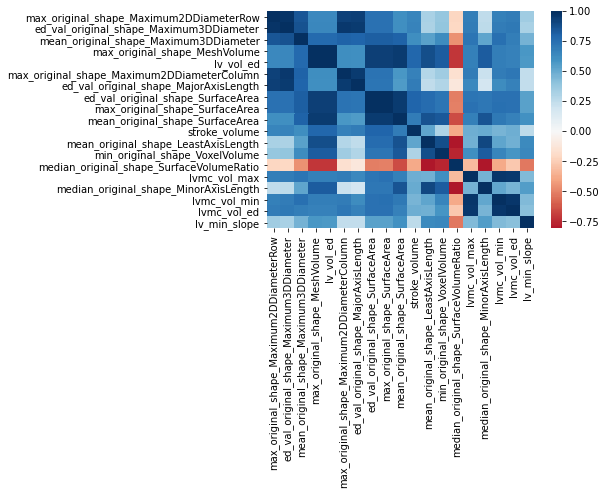

In [92]:
sns.heatmap(important_features_df[[ent[0] for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) \
                                   if ent[1] > 0.1]].corr(),cmap = 'RdBu', center = 0.0);

In [93]:
important_features_subset = ['max_original_shape_Maximum2DDiameterRow', 'median_original_shape_SurfaceVolumeRatio']
vif_values = [vif(important_features_df_scaled[important_features_subset].values, i) for i in range(len(important_features_subset))]
vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

max_original_shape_Maximum2DDiameterRow 1.839
median_original_shape_SurfaceVolumeRatio 1.839


In [94]:
multivariate_x = important_features_df_scaled[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][important_features_subset]
multivariate_y = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][['petco2']]

In [95]:
reg = LinearRegression().fit(multivariate_x, multivariate_y)
print('R^2 score =',round(reg.score(multivariate_x, multivariate_y),3))

R^2 score = 0.498


In [96]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     #'x2': multivariate_x[important_features_subset[2]], \
                     #'x3': multivariate_x[important_features_subset[3]], \
                     'y': multivariate_y.petco2.values})

In [97]:
model = ols("y ~ x0 + x1", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     23.27
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           9.45e-08
Time:                        10:25:07   Log-Likelihood:                -142.85
No. Observations:                  50   AIC:                             291.7
Df Residuals:                      47   BIC:                             297.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2358      1.740     13.927      0.0

### Hierarchical clustering

In [98]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import figure

In [99]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_font_size = 12, leaf_rotation = 0)
    return linkage_matrix

In [200]:
important_features_subset_shortlist =['lvmc_vol_min', 'median_original_shape_SurfaceVolumeRatio',\
            'max_original_shape_Maximum2DDiameterRow', \
            'lvmc_vol_ed', 'lv_std',\
            'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lv_min_slope',
 'lvmc_min_slope']

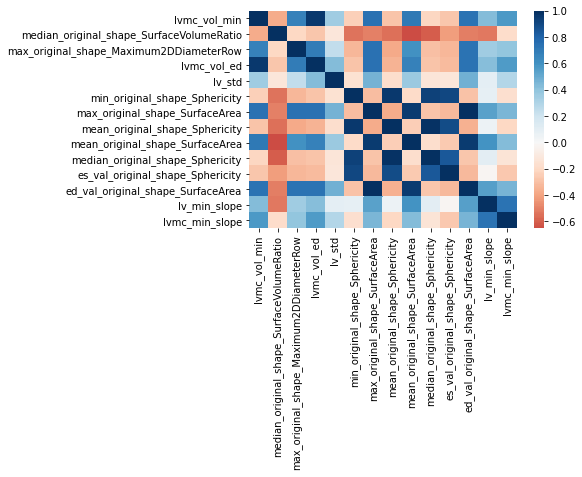

In [201]:
sns.heatmap(important_features_df[important_features_subset_shortlist].corr(),cmap = 'RdBu', center = 0.0);

In [204]:
important_features_subset_hcluster = ['lv_std', 'median_original_shape_Sphericity',\
 'median_original_shape_SurfaceVolumeRatio','max_original_shape_Maximum2DDiameterRow']
vif_values = [vif(important_features_df_scaled[important_features_subset_hcluster].values, i) for i in range(len(important_features_subset_hcluster))]
vif_feat_vals = {important_features_subset_hcluster[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

lv_std 4.372
max_original_shape_Maximum2DDiameterRow 3.717
median_original_shape_Sphericity 3.093
median_original_shape_SurfaceVolumeRatio 2.116


In [212]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
important_features_subset =['lv_std', 'median_original_shape_Sphericity']
multivariate_x = important_features_df_scaled[important_features_subset_hcluster]
model = model.fit(multivariate_x)

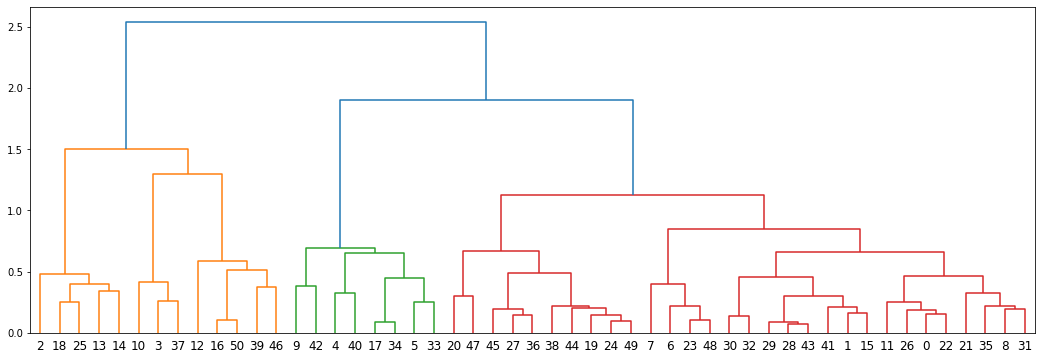

In [213]:
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)

In [216]:
clustering_model = AgglomerativeClustering(n_clusters=3)
clustering_model.fit(multivariate_x)
clustering_model.labels_

array([1, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 0])

In [140]:
cluster_0 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 0]
cluster_1 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 1]
cluster_2 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 2]

In [141]:
df = important_features_df_scaled.reset_index(drop=True)

In [142]:
cluster_0_ids = df.loc[cluster_0].patient_id.values
cluster_1_ids = df.loc[cluster_1].patient_id.values
cluster_2_ids = df.loc[cluster_2].patient_id.values

In [143]:
def cluster_condition(cluster):
    condition_arr = []
    for pid in cluster:
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        if condition.values[0] == 1.:
            condition_arr.append((pid,1))
        else:
            condition_arr.append((pid,0))
    return condition_arr

In [144]:
condition_arr_cluster_0 = cluster_condition(cluster_0_ids)
condition_arr_cluster_1 = cluster_condition(cluster_1_ids)
condition_arr_cluster_2 = cluster_condition(cluster_2_ids)

In [145]:
def count_high_low_vo2(condition_arr_cluster):
    count_0 = len([ent for ent in condition_arr_cluster if ent[1] == 0])
    count_1 = len([ent for ent in condition_arr_cluster if ent[1] == 1])
    
    return count_0, count_1

In [146]:
count_0_cluster_0, count_1_cluster_0 = count_high_low_vo2(condition_arr_cluster_0)
count_0_cluster_1, count_1_cluster_1 = count_high_low_vo2(condition_arr_cluster_1)
count_0_cluster_2, count_1_cluster_2 = count_high_low_vo2(condition_arr_cluster_2)

In [147]:
print(f'Cluster 0: 0:{count_0_cluster_0},  1:{count_1_cluster_0}')
print(f'Cluster 1: 0:{count_0_cluster_1},  1:{count_1_cluster_1}')
print(f'Cluster 2: 0:{count_0_cluster_2},  1:{count_1_cluster_2}')

Cluster 0: 0:2,  1:11
Cluster 1: 0:14,  1:16
Cluster 2: 0:3,  1:5


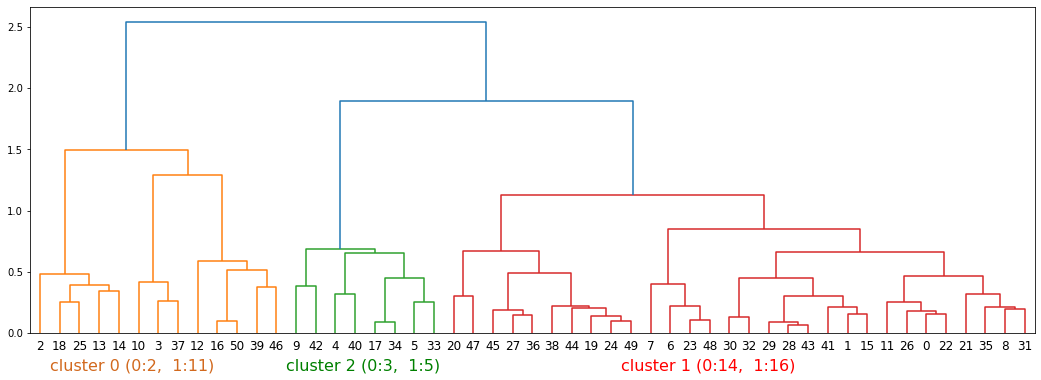

In [159]:
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)
y_pos = -0.3
plt.text(300,y_pos,f'cluster 1 (0:{count_0_cluster_1},  1:{count_1_cluster_1})',size=16, c='red')
plt.text(10,y_pos,f'cluster 0 (0:{count_0_cluster_0},  1:{count_1_cluster_0})',size=16, c='chocolate');
plt.text(130,y_pos,f'cluster 2 (0:{count_0_cluster_2},  1:{count_1_cluster_2})',size=16, c='green');

## Appendix

### 2D fractals

In [381]:
fractals_2d_csv = pd.read_csv(path+'/Golnoushs_fractals/fractals_2d.csv',header=None)
fractals_2d_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,PatientId,101B,101B,103,103,109,109,113B,113B,114,...,174,174,179,179,181,181,183,183,185,185
1,Phase,ed0,es4,ed0,es3,ed6,es2,ed7,es3,ed11,...,ed0,es3,ed0,es3,ed0,es3,ed0,es4,ed0,es3
2,lv_slope_1,-7.17244797022851e-07,-7.17244797022851e-07,-2.35006480096061,-2.60447083323098,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-3.40636875910898e-07,...,1.62022785767115,-4.23819458745847e-07,0.277345495270733,-7.17244797022851e-07,1.6700525232077e-14,1.6700525232077e-14,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07
3,lv_intercept_1,-13.8155093021575,-13.8155093021575,12.6947251769305,13.7171534320888,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155102541196,...,-0.573086769984424,-13.8155100200713,2.89753876193571,-13.8155093021575,-13.8155105579643,-13.8155105579643,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155093021575
4,lv_slope_2,-6.08596281514944e-07,-6.08596281514944e-07,-2.43939199316937,-2.4479288165968,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-3.35609746781348e-07,...,0.434298727343355,-1.33087932498926e-07,-0.291314529158718,-6.08596281514944e-07,2.4855571198563e-14,2.4855571198563e-14,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07


In [382]:
fractals_2d_df = fractals_2d_csv.T
header = fractals_2d_df.iloc[0]
fractals_2d_df = fractals_2d_df[1:] #take the data less the header row
fractals_2d_df.columns = header
fractals_2d_df.head()

,PatientId,Phase,lv_slope_1,lv_intercept_1,lv_slope_2,lv_intercept_2,lv_slope_3,lv_intercept_3,lv_slope_4,lv_intercept_4,...,lvmc_slope_21,lvmc_intercept_21,lvmc_slope_22,lvmc_intercept_22,lvmc_slope_23,lvmc_intercept_23,lvmc_slope_24,lvmc_intercept_24,lvmc_avg_slope,lvmc_avg_intercept
1,101B,ed0,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051
2,101B,es4,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051
3,103,ed0,-2.35006480096061,12.6947251769305,-2.43939199316937,12.9484620635241,-2.19220729127321,12.4161561492411,-2.10934424464303,11.967453763633,...,-2.81107435327764,13.327957478684,-3.05523401881432,14.1246362416685,-2.93141522958304,14.0178112699712,-2.98359681478104,14.1905277669756,-3.01555112093158,13.9224312935949
4,103,es3,-2.60447083323098,13.7171534320888,-2.4479288165968,13.1313412419052,-2.38185813403835,13.1508977626358,-2.36853101956377,12.5691216719384,...,-2.86080586867664,13.0201765724558,-3.02104624435245,13.7312840087983,-3.25400883841704,14.3806431536753,-2.99251575713431,14.6044052778162,-3.02894422463501,13.8165311315163
5,109,ed6,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051


In [383]:
fractals_2d_df_cols = fractals_2d_df.columns

for i in range(2,len(fractals_2d_df_cols)):
    fractals_2d_df[fractals_2d_df_cols[i]] = pd.to_numeric(fractals_2d_df[fractals_2d_df_cols[i]], errors='coerce')

In [384]:
num_rows = fractals_2d_df.shape[0]
for n in range(num_rows//2):
    fractals_2d_df.iat[2*n,1] = 'ed'
    
for n in range(num_rows//2):
    fractals_2d_df.iat[2*n+1,1] = 'es'

In [385]:
fractals_2d_ed = fractals_2d_df[fractals_2d_df.Phase=='ed']
fractals_2d_es = fractals_2d_df[fractals_2d_df.Phase=='es']

In [386]:
fractals_2d_ed.head()

,PatientId,Phase,lv_slope_1,lv_intercept_1,lv_slope_2,lv_intercept_2,lv_slope_3,lv_intercept_3,lv_slope_4,lv_intercept_4,...,lvmc_slope_21,lvmc_intercept_21,lvmc_slope_22,lvmc_intercept_22,lvmc_slope_23,lvmc_intercept_23,lvmc_slope_24,lvmc_intercept_24,lvmc_avg_slope,lvmc_avg_intercept
1,101B,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
3,103,ed,-2.350065e+00,12.694725,-2.439392e+00,12.948462,-2.192207e+00,12.416156,-2.109344e+00,11.967454,...,-2.811074e+00,13.327957,-3.055234e+00,14.124636,-2.931415e+00,14.017811,-2.983597e+00,14.190528,-3.015551,13.922431
5,109,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
7,113B,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
9,114,ed,-3.406369e-07,-13.815510,-3.356097e-07,-13.815510,-3.642006e-07,-13.815510,-4.502399e-07,-13.815510,...,-3.642006e-07,-13.815510,-4.502399e-07,-13.815510,-3.356097e-07,-13.815510,-3.406369e-07,-13.815510,0.000014,-13.815534


In [388]:
num_rows = fractals_2d_ed.shape[0]
num_cols = fractals_2d_ed.shape[1] - 2
scores = []

for c in range(2,num_cols):
    dyspnea_arr = []
    normal_arr = []

    for r in range(num_rows):
        arr = fractals_2d_ed.iloc[r][fractals_2d_ed.columns[c]]
        pid = fractals_2d_ed.iloc[r]['PatientId']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        #print(condition.values[0])
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    scores.append((fractals_2d_ed.columns[c], res.pvalue))

In [389]:
significant_scores_ed = [score for score in scores if score[1] < 0.05]
significant_scores_ed = sorted(significant_scores_ed, key=lambda significant_scores_ed: significant_scores_ed[1])

In [390]:
scores = []

for c in range(2,num_cols):
    dyspnea_arr = []
    normal_arr = []

    for r in range(num_rows):
        arr = fractals_2d_es.iloc[r][fractals_2d_es.columns[c]]
        pid = fractals_2d_es.iloc[r]['PatientId']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        #print(condition.values[0])
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    scores.append((fractals_2d_es.columns[c], res.pvalue))

In [391]:
significant_scores_es = [score for score in scores if score[1] < 0.05]
significant_scores_es = sorted(significant_scores_es, key=lambda significant_scores_es: significant_scores_es[1])

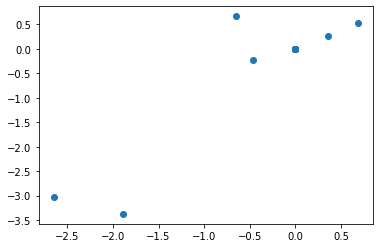

In [392]:
plt.scatter(fractals_2d_es['lv_slope_19'],fractals_2d_es['lvmc_slope_22'])

In [394]:
dyspnea_arr = []
normal_arr = []

for r in range(num_rows):
    arr = fractals_2d_es.iloc[r]['lv_slope_2']
    pid = fractals_2d_es.iloc[r]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    #print(condition.values[0])
    if condition.values[0] == 1.:
        dyspnea_arr.append(arr)
    else:
        normal_arr.append(arr)
scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)


MannwhitneyuResult(statistic=112.5, pvalue=0.024502933797889932)

In [395]:
Counter(dyspnea_arr)

Counter({-6.08596281514944e-07: 16,
         -2.4479288165968: 1,
         -3.35609746781348e-07: 1,
         -1.75320950347884: 1,
         -1.33087932498926e-07: 2,
         -0.36167615891756: 1,
         -0.33555203104179: 1,
         2.4855571198562998e-14: 1})

In [901]:
significant_features_es = [tup[0] for tup in significant_scores_es]
significant_features_ed = [tup[0] for tup in significant_scores_ed]

In [902]:
fractal_2d_es_df = fractals_2d_es[significant_features_es]
fractal_2d_ed_df = fractals_2d_ed[significant_features_ed]

In [904]:
fractal_2d_es_df.to_csv('fractal_2d_es.csv')